In [1]:
import torch
from torchvision import models
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

import glob
import random
import numpy as np
from PIL import Image
from byol_pytorch import BYOL
from matplotlib import pyplot as plt

/nfs/home/mirkat/anaconda3/envs/hw4_3090/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device used: ", device)

Device used:  cuda


In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Visualization

In [4]:
def imageshow(image):
  for t, m, s in zip(image, mean, std):
    t.mul_(s).add_(m)
  # reshape the img from (3, 32, 32) to (32, 32, 3)
  plt.imshow(np.transpose(image, (1, 2, 0)))
  plt.show()

In [5]:
def batchshow(dataloader):
  for images in dataloader:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    for image in images:
      for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    # reshape the img from (3, 32, 32) to (32, 32, 3)
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

# Custom Dataset & DataLoader

In [6]:
class HW4P2(Dataset):
    def __init__(self, dirpath, transform=None):
        self.filepaths = []
        self.transform = transform

        for fp in glob.glob(dirpath + '/*.jpg'):
            self.filepaths.append(fp)
    
    def __getitem__(self, index):
        fp = self.filepaths[index]
        image = Image.open(fp)
        if self.transform is not None:
            image = self.transform(image)
        return image
    
    def __len__(self):
        return len(self.filepaths)

In [7]:
trainset = HW4P2(
    dirpath='./hw4_data/mini/train/',
    transform=transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
)

In [8]:
print("# of images in trainset: ", len(trainset))

# of images in trainset:  38400


In [9]:
dataloader = {
    'train': DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4),
}

In [10]:
dataiter = iter(dataloader['train'])
images = dataiter.next()
print('Image tensor in each batch:', images.shape, images.dtype)

Image tensor in each batch: torch.Size([64, 3, 128, 128]) torch.float32


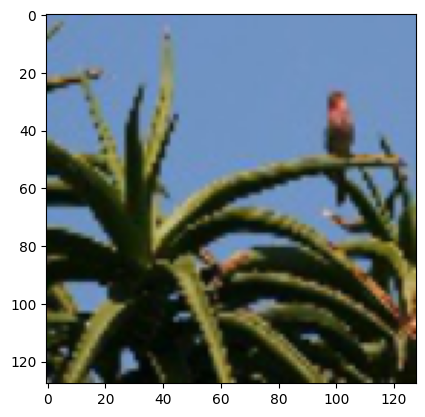

In [11]:
for i in range(1):
  sample = dataloader['train'].dataset[random.randint(0, len(dataloader['train']))]
  imageshow(sample)

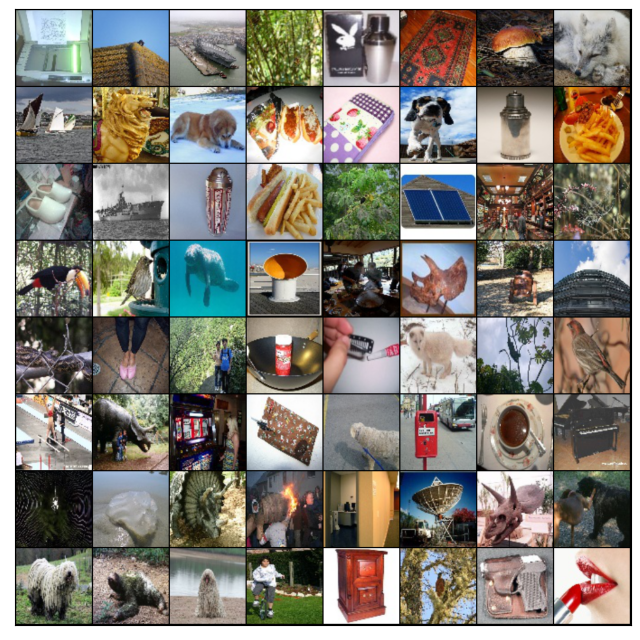

In [12]:
batchshow(dataloader['train'])

# Model

In [13]:
resnet = models.resnet50(weights=None)

In [14]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
learner = BYOL(
    resnet,
    image_size=128,
    hidden_layer='avgpool',
    use_momentum = False
)

# Training

In [16]:
opt = torch.optim.Adam(learner.parameters(), lr=3e-4)

In [18]:
resnet.load_state_dict(torch.load('./checkpoint/new_resnet_backbone.pt'))
learner = learner.to(device)
for epoch in range(28, 100):
    for _, images in enumerate(dataloader['train']):
        images = images.to(device)
        loss = learner(images)
        opt.zero_grad()
        loss.backward()
        opt.step()

    print(f'Epoch {epoch}')
    
    torch.save(resnet.state_dict(), './checkpoint/new_resnet_backbone_28.pt')        

Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46


KeyboardInterrupt: 